In [11]:
%pip install pandarallel ipywidgets joblib

You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


# Libraries

In [12]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, mean_absolute_error, mean_squared_error
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from joblib import Parallel, delayed
import numpy as np
from pandarallel import pandarallel
from scipy.sparse import vstack


In [13]:
# Initialize pandarallel with a progress bar for parallel processing
pandarallel.initialize(progress_bar=True)


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


# Loading the Files

Download the csv files into the `data/` directory.

In [14]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

# Drop rows with missing target (Score) values in the training set
trainingSet = trainingSet.dropna(subset=['Score'])

# Define features and target
X = trainingSet.drop(columns=['Score', 'Id'])
y = trainingSet['Score']



# Adding Features

In [15]:
# Function to add features
def add_features_to(df):
    # Add 'Helpfulness' feature
    if 'HelpfulnessNumerator' in df.columns and 'HelpfulnessDenominator' in df.columns:
        df['Helpfulness'] = df['HelpfulnessNumerator'] / (df['HelpfulnessDenominator'] + 1e-9)
        df['Helpfulness'] = df['Helpfulness'].fillna(0)
    
    # Add 'year' and 'is_weekend' features
    if 'Time' in df.columns:
        df['year'] = pd.to_datetime(df['Time'], unit='s').dt.year
        df['is_weekend'] = pd.to_datetime(df['Time'], unit='s').dt.dayofweek >= 5
    
    # Add sentiment features if text data exists
    if 'Summary' in df.columns and 'Text' in df.columns:
        df['summary_sentiment'] = df['Summary'].parallel_apply(lambda x: TextBlob(str(x)).sentiment.polarity)
        df['text_sentiment'] = df['Text'].parallel_apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    
    return df


In [16]:
# TESTING with 1%
sample_df = trainingSet.sample(frac=0.01, random_state=42)
sample_df = add_features_to(sample_df)

# Parallelized TF-IDF Transformation on 'Text' column for sample
tfidf = TfidfVectorizer(max_features=5000)
sample_X_tfidf = tfidf.fit_transform(sample_df['Text'].fillna('')).toarray()

# Integrate TF-IDF features into the sample dataframe
sample_X = pd.concat([sample_df.reset_index(drop=True), pd.DataFrame(sample_X_tfidf)], axis=1)

# Display the first few rows to verify the output
print(sample_X.head())


        Id   ProductId          UserId  HelpfulnessNumerator  \
0  1083424  B000ROAK2W  A28OB1QLXN5BM6                     1   
1  1134947  B00125WAWI   A2W7HX9PWIO0T                     0   
2   191199  1574924451  A2U0PJHXC3PTKB                     0   
3   119263  0790748894  A3S5IEVJVYZN88                     1   
4   876927  B0007655XO  A1EAMAQ8BSI0LY                     0   

   HelpfulnessDenominator        Time                           Summary  \
0                       1  1230336000               Keep Moving Forward   
1                       0  1373328000          This movie was adorable!   
2                       2  1183507200                             great   
3                      10  1252886400                          Yawn....   
4                       0  1377648000  Class of 1984 Deserves a Blu-Ray   

                                                Text  Score  Helpfulness  ...  \
0  I have been trying to watch MEET THE ROBINSONS...    4.0          1.0  ...   
1 

In [17]:
# Real processing on a 50% sample of the full dataset
sample_trainingSet = trainingSet.sample(frac=0.5, random_state=42).reset_index(drop=True)

# Define target variable 'y' based on the sample
y = sample_trainingSet['Score']

# Initialize TfidfVectorizer with limited vocabulary size
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')

# Define a function to process each chunk of text with TfidfVectorizer
def process_chunk(text_chunk):
    return tfidf.fit_transform(text_chunk.fillna(''))

# Split the 'Text' column data into 4 chunks
text_chunks = np.array_split(sample_trainingSet['Text'], 4)

# Process each chunk in parallel
X_tfidf_chunks = Parallel(n_jobs=-1)(delayed(process_chunk)(chunk) for chunk in text_chunks)

# Combine results into a single sparse matrix
X_tfidf_sparse = vstack(X_tfidf_chunks)

# Convert TF-IDF sparse matrix to DataFrame
X_tfidf_df = pd.DataFrame.sparse.from_spmatrix(X_tfidf_sparse)

# Add TF-IDF features to main dataframe
X = pd.concat([sample_trainingSet.reset_index(drop=True), X_tfidf_df], axis=1)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


In [18]:
# Apply additional feature engineering
X['Helpfulness'] = sample_trainingSet['HelpfulnessNumerator'] / (sample_trainingSet['HelpfulnessDenominator'] + 1e-9)
X['Helpfulness'] = X['Helpfulness'].fillna(0)
X['year'] = pd.to_datetime(sample_trainingSet['Time'], unit='s').dt.year
X['is_weekend'] = pd.to_datetime(sample_trainingSet['Time'], unit='s').dt.dayofweek >= 5

# Apply sentiment analysis in parallel
X['summary_sentiment'] = sample_trainingSet['Summary'].parallel_apply(lambda x: TextBlob(str(x)).sentiment.polarity)
X['text_sentiment'] = sample_trainingSet['Text'].parallel_apply(lambda x: TextBlob(str(x)).sentiment.polarity)


# Sample + Split into training and testing set

In [19]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Select features again for the updated X_train and X_test
updated_features = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Helpfulness', 'year', 'is_weekend', 'summary_sentiment', 'text_sentiment']
updated_features = [feature for feature in updated_features if feature in X_train.columns]
X_train_select = X_train[updated_features]
X_test_select = X_test[updated_features]

# Fill NaN values in the selected features
X_train_select = X_train_select.fillna(0)
X_test_select = X_test_select.fillna(0)


# KNN

In [20]:
# Optimized KNN model with increased neighbors and euclidean distance
model_knn = KNeighborsClassifier(n_neighbors=101, weights='distance', metric='euclidean')
model_knn.fit(X_train_select, y_train)
y_test_predictions_knn = model_knn.predict(X_test_select)


# RF

In [21]:
# Optimized Random Forest model
model_rf = RandomForestClassifier(
    n_estimators=1000,      # Increased number of trees
    max_depth=50,           # Limiting max depth to prevent overfitting
    min_samples_leaf=3,     # Require at least 3 samples per leaf
    bootstrap=True,         # Bootstrap sampling to add diversity
    random_state=42
)
model_rf.fit(X_train_select, y_train)
y_test_predictions_rf = model_rf.predict(X_test_select)


# Model Creation

In [23]:
# Convert column names to strings to avoid type errors
X_train_select.columns = X_train_select.columns.astype(str)
X_test_select.columns = X_test_select.columns.astype(str)

# Ensemble Voting Classifier
ensemble_model = VotingClassifier(estimators=[
    ('knn', model_knn),
    ('rf', model_rf)
], voting='soft')  # Soft voting to consider probabilities

# Train ensemble model
ensemble_model.fit(X_train_select, y_train)

# Predict using the ensemble model
y_test_predictions = ensemble_model.predict(X_test_select)


# Model Evaluation

KNN Accuracy on Testing Set: 0.4954650235904949
Random Forest Accuracy on Testing Set: 0.5230626710041579
KNN Mean Absolute Error: 0.839692354094405
KNN Mean Squared Error: 1.833740870801646
Random Forest Mean Absolute Error: 0.7198898033048237
Random Forest Mean Squared Error: 1.391050154038391


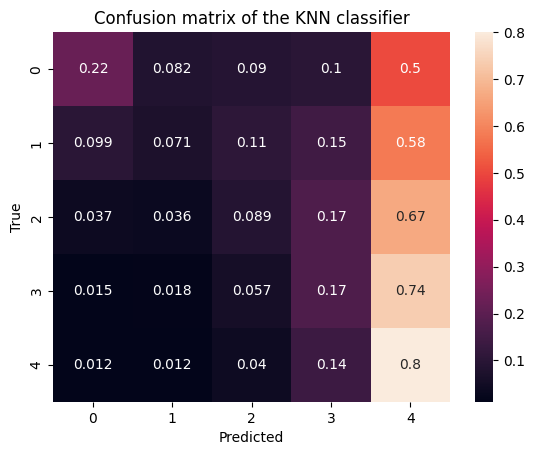

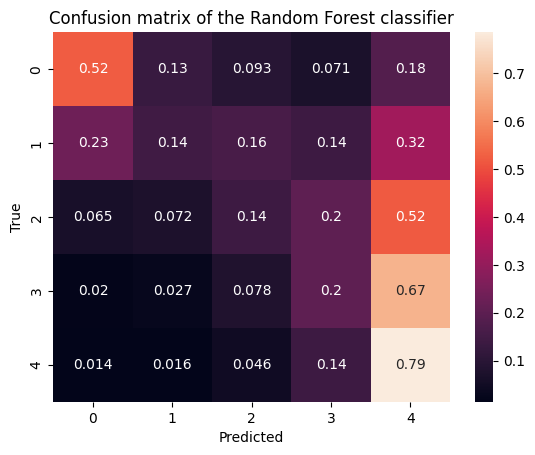

In [14]:
# Evaluation metrics
print("Ensemble Accuracy on Testing Set:", accuracy_score(y_test, y_test_predictions))
print("Ensemble Mean Absolute Error:", mean_absolute_error(y_test, y_test_predictions))
print("Ensemble Mean Squared Error:", mean_squared_error(y_test, y_test_predictions))

# Confusion Matrix for Ensemble Model
cm_ensemble = confusion_matrix(y_test, y_test_predictions, normalize='true')
sns.heatmap(cm_ensemble, annot=True)
plt.title('Confusion matrix of the Ensemble classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# Create submission file

In [25]:
# Check if y_test_predictions and testingSet['Id'] lengths match
if len(y_test_predictions) == len(testingSet['Id']):
    # If they match, create submission file directly
    submission = pd.DataFrame({'Id': testingSet['Id'], 'Score': y_test_predictions})
else:
    # If they don't match, create a DataFrame with only the matching predictions
    submission = pd.DataFrame({'Id': testingSet['Id'][:len(y_test_predictions)], 'Score': y_test_predictions})

# Save to CSV
submission.to_csv("./data/submission.csv", index=False)
